In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
#dataset = load("moon.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
variant = :sigma
    # :unit - output has unit variance
    # :sigma - the variance of the output is estimated
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
# decoder architecture
(variant == :unit)? dsize = [latentdim; hiddendim; hiddendim; indim] :
    dsize = [latentdim; hiddendim; hiddendim; 2*indim]
lambda = 1e-3 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
batchsize = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = Inf # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
eta = 0.001
model = VAEmodel(esize, dsize, lambda = lambda, threshold = threshold, 
    contamination = contamination, iterations = iterations, cbit = cbit, 
    verbfit = verbfit, batchsize = batchsize, M=M, activation = activation, layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked, variant = variant, eta = eta)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#samplenormal,Flux.Chain,Val{:sigma}}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.samplenormal, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), Val{:sigma}()), 0.001, 0, 0.1262135922330097, 2000, 500, true, 50, 1, Inf32, 1.0f0, MVHistory{ValueHistories.History}, "likelihood", 0.001)

In [4]:
# fit the model
println("\ninitial loss")
AnomalyDetection.evalloss(model, nX)
@time AnomalyDetection.fit!(model, nX)
println("\nfinal loss")
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)


initial loss
loss: 0.8109295
likelihood: 0.5586316
KL: 0.270632



Progress:   0%|                                         |  ETA: 1:12:16
  loss:        0.75854284
  likelihood:  0.57041115
Progress:  12%|█████                                    |  ETA: 0:00:22
  loss:        0.75854284
  likelihood:  0.57041115
Progress:  18%|████████                                 |  ETA: 0:00:14
  loss:        0.75854284
  likelihood:  0.57041115
Progress:  24%|██████████                               |  ETA: 0:00:11
  loss:        0.75854284
  likelihood:  0.57041115
Progress:  31%|█████████████                            |  ETA: 0:00:09
  loss:        -3.2187307
  likelihood:  -3.4206262
Progress:  38%|████████████████                         |  ETA: 0:00:07
  loss:        -3.2187307
  likelihood:  -3.4206262
Progress:  45%|██████████████████                       |  ETA: 0:00:06
  loss:        -3.2187307
  likelihood:  -3.4206262
Progress:  52%|█████████████████████                    |  ETA: 0:00:04
  loss:        -4.7553325
  likelihood:  -4.7193933
Progress

-4.763289f0

  8.326524 seconds (13.45 M allocations: 1.743 GiB, 3.63% gc time)

final loss
loss: -8.361506
likelihood: -8.385181
KL: 33.049423



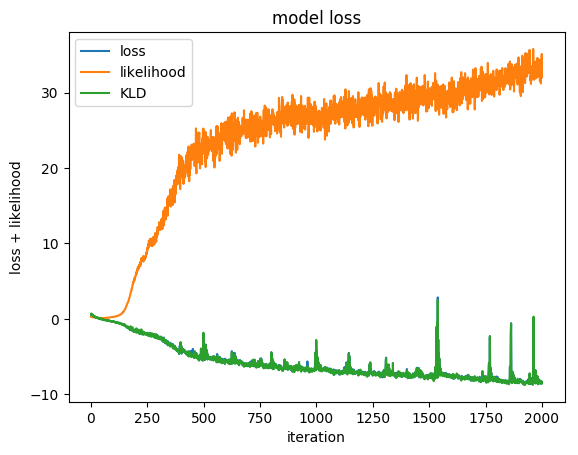

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 4×90 Array{Float32,2}:
   0.801695    0.803016    0.804733  …   0.0394964   0.0623351   0.0648629
   0.816611    0.823261    0.824691      0.975488    0.991494    0.997776 
 -12.1749    -12.2091    -12.2258       -9.42786    -9.62573    -9.70522  
  -8.37555    -8.39956    -8.41049      -7.73178    -7.86495    -7.92489  

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mux(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.801887  0.802763  0.805238  0.818055  …  0.0304547  0.0586395  0.0635091
 0.816163  0.823082  0.819791  0.833503     0.989368   0.998849   0.995717 

In [9]:
AnomalyDetection.sigma2x(model, nX)

Tracked 2×90 Array{Float32,2}:
 6.12599f-6   6.00678f-6   5.88757f-6   …  4.41528f-5   8.6827f-5  
 0.000229975  0.000226638  0.000224492     0.000273356  0.000477604

What are the parameters of $q(z|x)$?

In [10]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
  3.64911   3.7034    3.66405   3.75139  …   5.12425   5.24924   5.08696
 -7.96453  -7.97807  -7.99387  -8.0949      -2.27695  -2.4873   -2.52705

In [11]:
AnomalyDetection.sigma2z(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.0025455   0.00243907  0.0024889   0.00224807  …  0.00842581  0.00925424 
 1.23842f-6  1.23842f-6  1.23842f-6  1.23842f-6     0.00018826  0.000202443

What do the codes look like?

In [12]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
  3.6584    3.77196   3.59795   3.79874  …   5.06434   5.38306   5.0868 
 -7.96522  -7.97601  -7.99382  -8.09524     -2.31649  -2.46891  -2.53462

In [13]:
# predict labels on testing data
model.M = 10 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [14]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
f1score: 0.9629629629629629
recall: 1.0
false positive rate: 0.011111111111111112
equal error rate: 0.005555555555555556


In [15]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 30);


 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
f1score: 0.9629629629629629
recall: 1.0
false positive rate: 0.011111111111111112
equal error rate: 0.005555555555555556


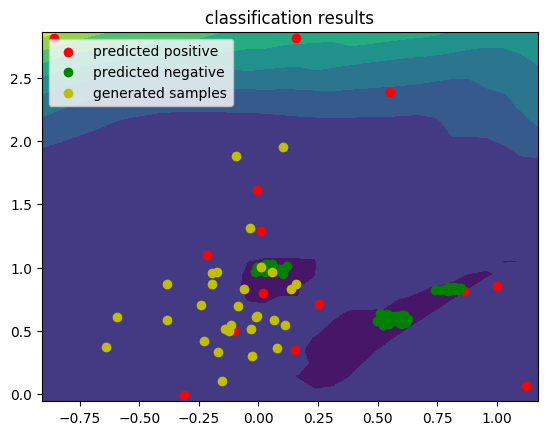

In [16]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

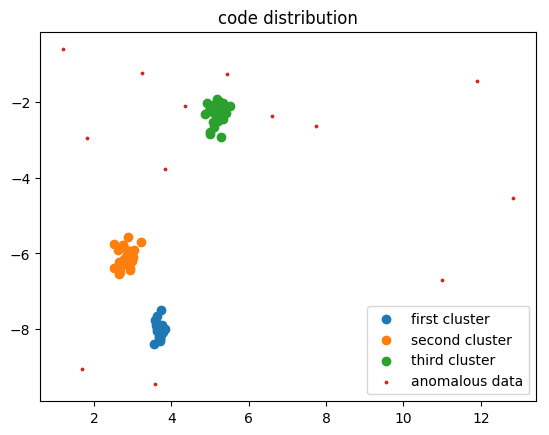

In [17]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

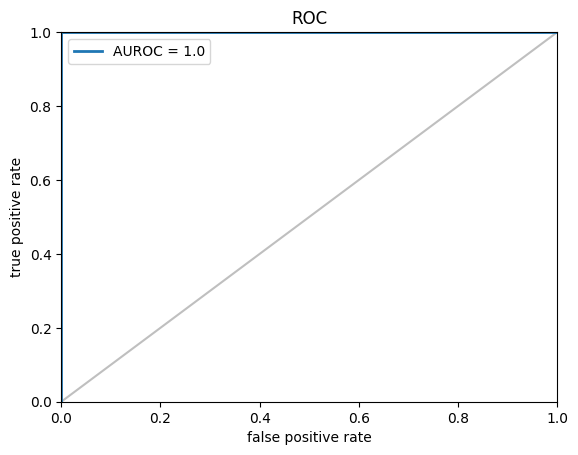

In [18]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()